In [1]:
%%time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import pandas as pd
import numpy as np
import scipy.io.wavfile
from scipy import fftpack

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

from os import sep
from os.path import isfile, join, abspath
from moviepy.editor import AudioFileClip, VideoFileClip, concatenate_videoclips, concatenate_audioclips

from sklearn.decomposition import PCA
from ggplot import *

CPU times: user 993 ms, sys: 187 ms, total: 1.18 s
Wall time: 1.29 s


In [2]:
dirpath = join(abspath(sep),'Users/brianschneider/Desktop/capstone/gameSummarizer')
file_basename = 'trainingData'
eventFileName = join('.', file_basename+'.csv')
event_data = pd.read_csv(eventFileName, sep=',',header=0)
print(len(event_data),' events loaded')

86  events loaded


In [3]:
# Compute offset of each clip in the new clips collection and add to DataFrame
offset=np.cumsum(event_data["timeToCapture"])
event_data["offset"]=offset-event_data["timeToCapture"]
# Prepare a list of labels
labels=[row["eventName"] 
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]

# Concatenate video clips using ffmpeg (fast but audio gets out of sync)
This approach needs more work. In the mean time use the slower videoPy option below

In [4]:
#for index, row in event_data.iterrows():
#    #print row['secondOffset'], row['timeToCapture']
#    if row['fileName'] == file_basename+'.wav':
#        outFileName=os.path.join(dirpath, file_basename+str(index)+'.mp4')
#        print 'Writing clip #',index,' from sec ',row['secondOffset'],' length ',row['timeToCapture']
#        ffmpeg_extract_subclip(videoFileName, row['secondOffset'], row['secondOffset']+row['timeToCapture'], targetname=outFileName)
#    else:
#        print 'Skipping ', row['fileName']

# https://trac.ffmpeg.org/wiki/Concatenate
Getting error: "IOPub data rate exceeded"?

Add the following as a parameter to 'Jupyter notebook': --NotebookApp.iopub_data_rate_limit=50000000
or upgrade Jupyter notebook to 5.1

# Concatenate video clips using videoPy


In [5]:
# %%time
# clips=[]
# for index, row in event_data.iterrows():
#     #print row['secondOffset'], row['timeToCapture']
#     videoFileName = join(dirpath, row['fileName'])
#     if isfile(videoFileName):
#         videoClip = VideoFileClip(videoFileName).subclip(row['secondOffset'],row['secondOffset']+row['timeToCapture'])
#         clips.append(videoClip)
#     else:
#         print('Could not find file ', videoFileName)
    
# final_clip = concatenate_videoclips(clips)
# final_clip.write_videofile(join(dirpath, "my_concatenation.mp4"))


In [6]:
# for clip in clips:
#     del clip

# Play a video clip

In [7]:
# # Utility: Play a video clip from file starting at <offset> (in seconds) for <length> (in seconds)
# def getClip(path=join(dirpath, "my_concatenation.mp4"),offset=0,length=30):
#     videoClip = VideoFileClip(path).subclip(offset,offset+length)
#     return videoClip

In [8]:
# def getEvent(eventNumber):
#     o=int(event_data.iloc[eventNumber-1]["offset"])
#     l=int(event_data.iloc[eventNumber-1]["timeToCapture"])
#     return getClip(offset=o, length=l)

Play an event number from event file (first event is #1)

In [9]:
# clip = getEvent(44)  
# clip.ipython_display(width=640, autoplay=True)  

Play a portion of a clip using offset and length in seconds 

In [10]:
# clip = getClip(offset=0,length=15) 
# clip.ipython_display(width=640, autoplay=True)  

# Concatenate audio clips

In [11]:
# %%time
# clips = []
# for index, row in event_data.iterrows():
#     #print row['secondOffset'], row['timeToCapture']
#     videoFileName = join(dirpath, row['fileName'])
#     if isfile(videoFileName):
#         audioClip = AudioFileClip(videoFileName).subclip(row['secondOffset'],row['secondOffset']+row['timeToCapture'])
#         clips.append(audioClip)
#     else:
#         print 'Could not find file ', videoFileName

# final_clip = concatenate_audioclips(clips)
# final_clip.write_audiofile(join(dirpath, "my_concatenation.mp3"))
# #final_clip.write_videofile("/temp/my_concatenation.mp3")
# #final_clip.ipython_display("/temp/my_concatenation.mp3",width=640, autoplay=True)
# for clip in clips:
#     del clip.reader
#     del clip

# Play first 30 seconds of audio clip

In [12]:
# final_clip.set_end(30).ipython_display(join(dirpath, "my_concatenation.mp3"),width=640, autoplay=True)

# Convert audio to WAV for ease of audio processing

In [13]:
#   import subprocess
#   audioFile = join(dirpath, "my_concatenation.mp3")
#   subprocess.call(['ffmpeg', '-y', '-i', audioFile,
#                    join(dirpath, "my_concatenation.wav")])  

# Perform FFT on audio in WAV format

In [14]:
audioFile = join(dirpath, "my_concatenation.wav")  
samprate, wavdata = scipy.io.wavfile.read(audioFile)
clipDurationInSec = wavdata.shape[0]/samprate
# wavdata is (clipLengthInSec * samprate) X (2 channels: [0] is left, [1] is right )
# Sample rate is 44,100
print(samprate)
print(wavdata.shape[0]/samprate)

44100
1300.0


In [15]:
%%time
F = []
# Perform fft, take only positive freq. (22,050 samples) 
#  then calulate the absolute value to include both real and imaginary parts
wavdata2 = wavdata.reshape(-1, samprate,  2)
# wavdata2 = wavdata.reshape(wavdata.shape[0]/samprate, samprate,  2L)
dims = wavdata2.shape
for sec in np.arange(dims[0]):
    ch1 = scipy.fftpack.fft(wavdata2[sec,:,0])[:samprate//2] # Left channel
    ch2 = scipy.fftpack.fft(wavdata2[sec,:,1])[:samprate//2] # Right channel
    ch = np.vstack([ch1,ch2])
    F.append(ch)
F = np.absolute(F)/samprate
F_db = 20*np.log10(2*F)  # Dimensions are (seconds, channels, samples)
f = scipy.fftpack.fftfreq(samprate, 1.0/samprate)[:samprate//2]

CPU times: user 3.96 s, sys: 1.09 s, total: 5.05 s
Wall time: 5.07 s


# Plot frequency vs. amplitude

In [16]:
def plotFrequencySpectrum(second):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 3)
    plt.plot(f,np.transpose(F_db[second-1,:,:]), alpha=0.5)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude(in dB)')
    plt.subplot(1, 3, 2)
    plt.plot(f,np.transpose(F[second-1,:,:]), alpha=0.4)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.subplot(1, 3, 1)
    plt.plot(wavdata2[second-1,:,], alpha=0.4)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

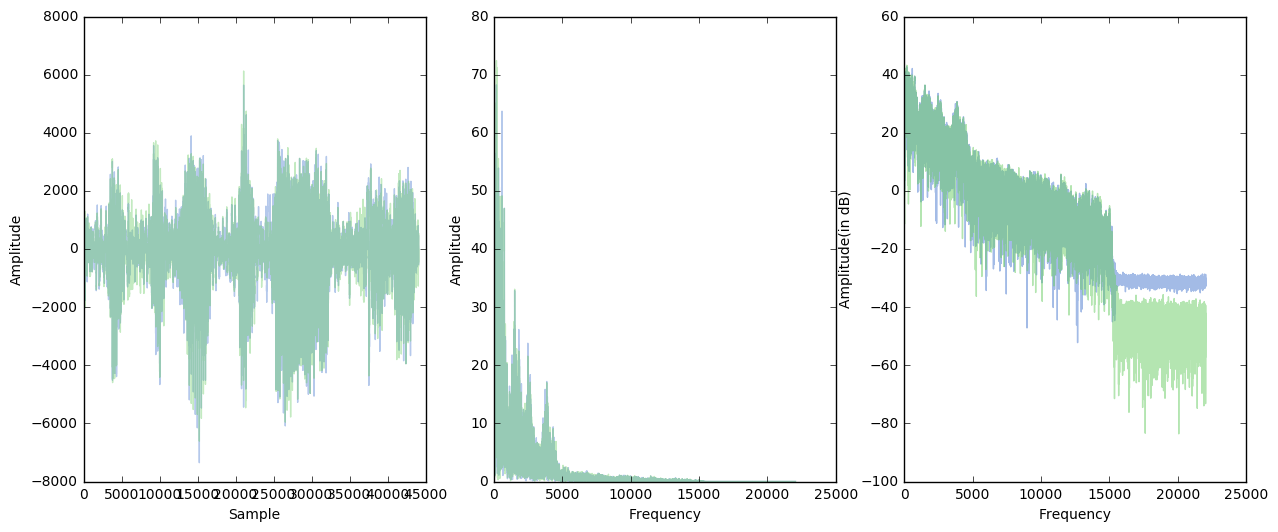

In [17]:
plotFrequencySpectrum(16)

# Dimentionality reduction: PCA

In [18]:
# a handy function for vizualizing principle components as a heatmap
# this allows you to see what dimensions in the 'original space' are
# active

def visualize_pca_comps_heatmap(plot, comps):
    heatmap = plot.pcolor(comps, cmap=plt.cm.Blues)
    
    x_lab = [i for i in range(comps.shape[1])]
    y_lab = [i for i in (range(comps.shape[0]))]
    
    plot.set_xticks(np.arange(comps.shape[1])+0.5, minor=False)
    plot.set_yticks(np.arange(comps.shape[0])+0.5, minor=False)
    
    # want a more natural, table-like display
    plot.invert_yaxis()
    
    plot.set_xticklabels(x_lab, minor=False)
    plot.set_yticklabels(y_lab, minor=False)
    
    plt.title('Heatmap of PCA components Rows: components, Cols: Original dimensions')

In [19]:
print (F.shape)
F2 = F.reshape(F.shape[0],-1)
print (F2.shape)

(1300, 2, 22050)
(1300, 44100)


Explained variance ratio: 
 [ 0.00083192  0.00082568  0.00082295  0.00081809  0.00081431  0.00080529
  0.00080382  0.00079025  0.00078815  0.00078433  0.00078189  0.00077477
  0.00075999  0.00075479  0.00075072  0.00074942  0.00074703  0.00074039
  0.00073325  0.00072944]
Explained variance ratio: 
 (150,)
Cumulative explained variance: 
 [ 0.73529392  0.73611959  0.73694255  0.73776063  0.73857495  0.73938024
  0.74018406  0.74097431  0.74176246  0.74254679  0.74332868  0.74410345
  0.74486344  0.74561823  0.74636895  0.74711837  0.7478654   0.74860579
  0.74933904  0.75006848]
PCA components: 
 (150, 44100)
CPU times: user 15.8 s, sys: 1.31 s, total: 17.2 s
Wall time: 4.97 s


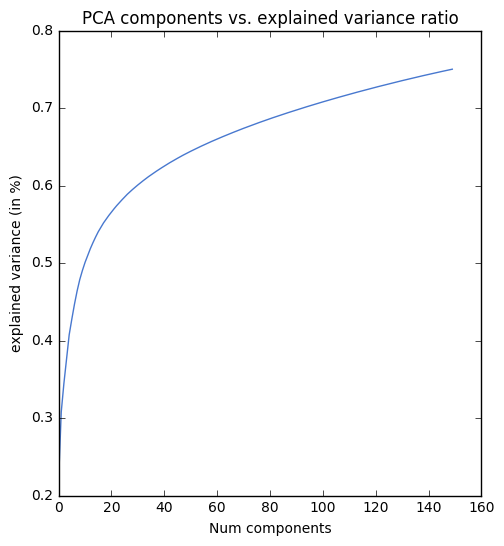

In [20]:
%%time
n_components = 150
pca_model = PCA(n_components)
pca_model.fit(F2)

print('Explained variance ratio: \n', pca_model.explained_variance_ratio_[-20:])
print('Explained variance ratio: \n', pca_model.explained_variance_ratio_.shape)
print('Cumulative explained variance: \n', np.cumsum(pca_model.explained_variance_ratio_)[-20:])
print('PCA components: \n', pca_model.components_.shape)

plt.figure(figsize=(12, 6))
#p2 = plt.subplot(1, 2, 1)
#visualize_pca_comps_heatmap(p2, model.components_)
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('Num components')
plt.ylabel('explained variance (in %)')
plt.title('PCA components vs. explained variance ratio')

In [21]:
# Apply PCA Transformation to the input to create embeddings

In [22]:
%%time
print(F2.shape)
t= pca_model.transform(F2)
print(t.shape)

(1300, 44100)
(1300, 150)
CPU times: user 1.24 s, sys: 165 ms, total: 1.41 s
Wall time: 455 ms


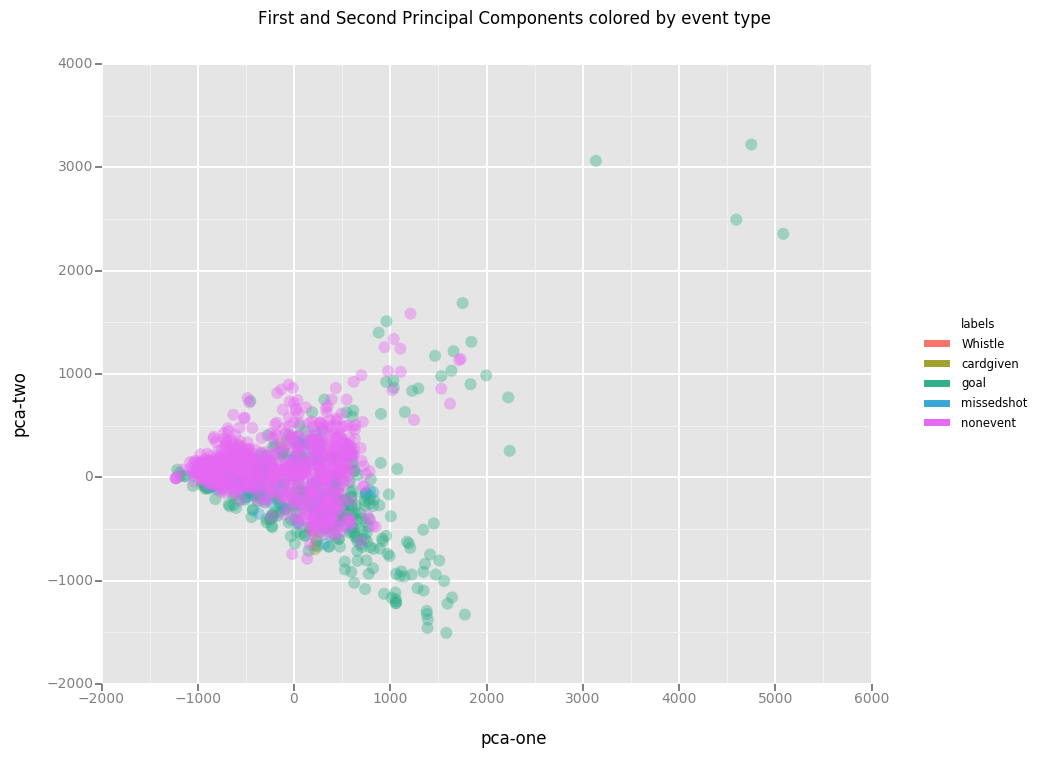

<ggplot: (-9223372036566353250)>

In [23]:
df_pca = pd.DataFrame(t[:,0], columns=["pca-one"])
df_pca["pca-two"] = t[:,1]
df_pca["labels"] = labels


chart = ggplot( df_pca, aes(x='pca-one', y='pca-two', color='labels') ) \
        + geom_point(size=75,alpha=0.4) \
        + ggtitle("First and Second Principal Components colored by event type")
chart

## Try tSNE
Use the reduced dimensions as were produced by PCA (to improve performance)

In [24]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=900, learning_rate=20)
tsne_results = tsne.fit_transform(t)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1300
[t-SNE] Computed conditional probabilities for sample 1300 / 1300
[t-SNE] Mean sigma: 146.260042
[t-SNE] KL divergence after 50 iterations with early exaggeration: 2.049384
[t-SNE] Error after 125 iterations: 2.049384
CPU times: user 2.11 s, sys: 465 ms, total: 2.58 s
Wall time: 2.56 s


In [25]:
df_tsne = pd.DataFrame(tsne_results[:,0], columns=["x-tsne"])
df_tsne["y-tsne"] = tsne_results[:,1]
df_tsne["labels"] = labels

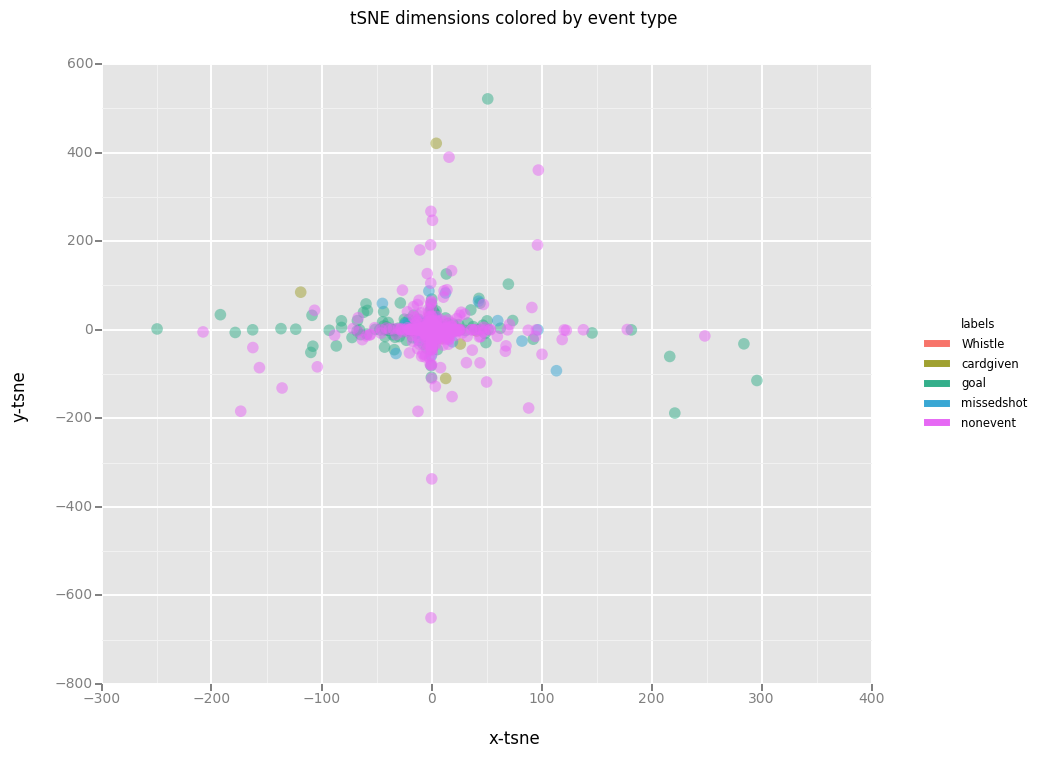

<ggplot: (290189397)>

In [26]:
chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='labels') ) \
        + geom_point(size=70,alpha=0.5) \
        + ggtitle("tSNE dimensions colored by event type")
chart

##  Try truncated SVD

In [27]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=n_components, n_iter=17, random_state=42)
svd_results = svd.fit_transform(F2)
print(svd.explained_variance_ratio_) 
print(svd.explained_variance_ratio_.sum()) 

[ 0.21391341  0.08787234  0.04031244  0.0325734   0.03161907  0.02036174
  0.01921809  0.01716978  0.01466844  0.01194554  0.01044597  0.00902898
  0.00874032  0.00782338  0.0072528   0.00680476  0.00582154  0.00567813
  0.0048962   0.00473983  0.00436201  0.00433812  0.00409698  0.00383918
  0.00371776  0.00360011  0.00352293  0.0031984   0.00303352  0.00293122
  0.00286814  0.00278145  0.00267097  0.00261396  0.00256145  0.00240299
  0.00236421  0.00233504  0.00227751  0.00217985  0.00214441  0.00212414
  0.00211309  0.0020113   0.00194398  0.00194272  0.00191824  0.00186507
  0.00180908  0.00175395  0.00170879  0.00168798  0.00166622  0.00164972
  0.00162618  0.00159123  0.00155678  0.00155022  0.0015256   0.00150103
  0.00146831  0.00145456  0.00144085  0.00143047  0.00140446  0.00138801
  0.00137519  0.00137458  0.00135417  0.00134438  0.00130547  0.00129373
  0.00128729  0.00127167  0.00126386  0.00125482  0.00123767  0.0012317
  0.00122027  0.00120202  0.00119813  0.00118494  0.

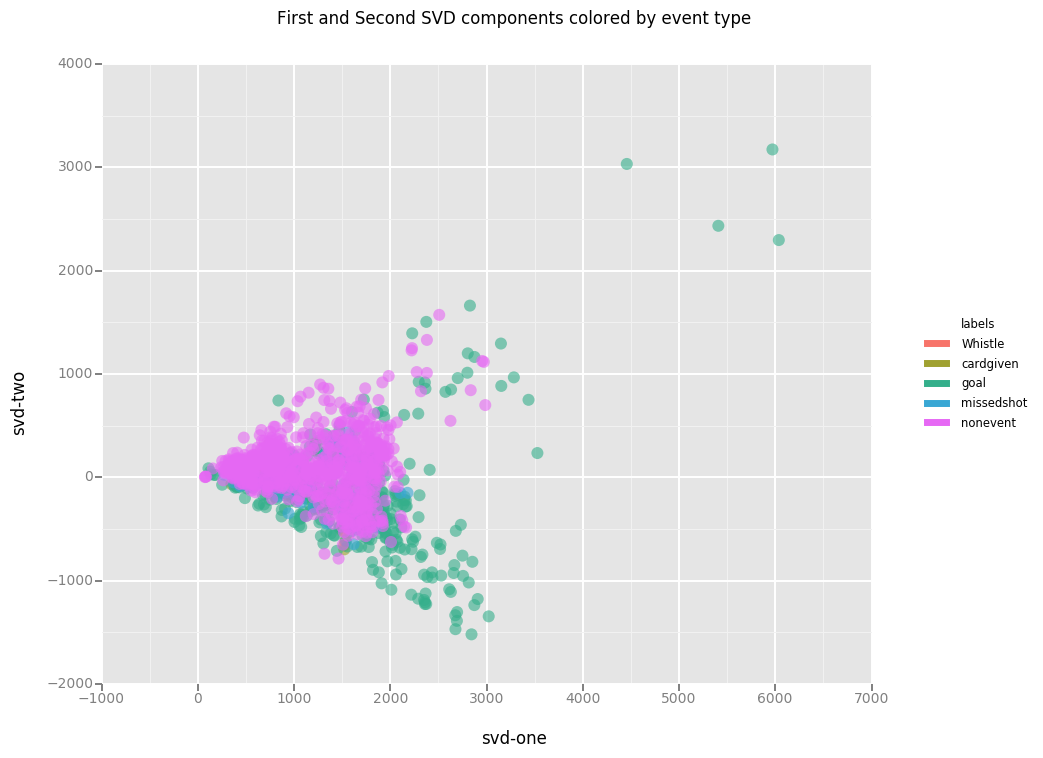

<ggplot: (-9223372036579427861)>

In [28]:
df_svd = pd.DataFrame(svd_results[:,0], columns=["svd-one"])
df_svd["svd-two"] = svd_results[:,1]
df_svd["labels"] = labels


chart = ggplot( df_svd, aes(x='svd-one', y='svd-two', color='labels') ) \
        + geom_point(size=75,alpha=0.6) \
        + ggtitle("First and Second SVD components colored by event type")
chart

# Classifiers

## Prepare training and test Data Sets

In [29]:
from sklearn.model_selection import train_test_split
index=np.array(np.arange(len(labels)))
data=pca_model.transform(F2)
data_train, data_test, labels_train, labels_test, index_train, index_test = train_test_split(data, labels, index, test_size=0.20, random_state=42)

## Utilities

In [30]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## KNN Classifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

model = KNeighborsClassifier(n_neighbors=6)
model.fit(data_train, labels_train)
test_predicted_labels = model.predict(data_test)

wrong_prediction = (test_predicted_labels != labels_test)

print('number of incorrect predictions:', np.sum(wrong_prediction))

number of incorrect predictions: 59


In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels, average="macro")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels, average="macro")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels, average="macro")))   

accuracy: 77.3%
F1 score: 39.3%
Precision: 47.3%
Recall: : 37.1%


Confusion matrix, without normalization
[[  0   0   1   1   0]
 [  0   1   1   0   5]
 [  0   1  51   2  25]
 [  0   0   3   2  12]
 [  0   0   5   3 147]]


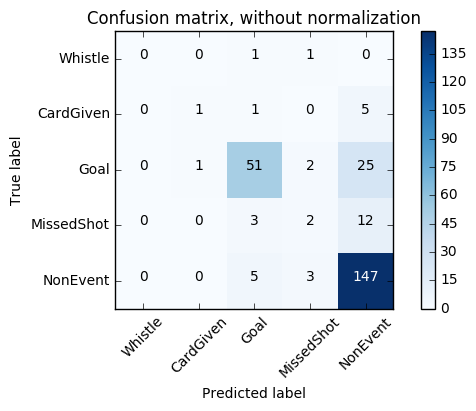

In [33]:
cnf_matrix = confusion_matrix(labels_test, test_predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Whistle","CardGiven","Goal","MissedShot","NonEvent"],
                      title='Confusion matrix, without normalization')

In [34]:
l=['#'+str(index+1)+': '+row["fileName"]+','+str(row["secondOffset"])+','+str(i-row["offset"]+1)+','+row["eventName"]
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]

In [35]:
l1=index_test[(np.array(labels_test) == 'goal') & (np.array(test_predicted_labels) == 'nonevent')]

In [36]:
l=np.array(l)

In [37]:
l[l1]

array(['#17: AUG-BVB_1st_half_ENG.mp4,764,1,goal',
       '#55: cel_bay_2nd_half_eng.mp4,1940,1,goal',
       '#79: rom_v_che_2nd_half_eng.mp4,1055,1,goal',
       '#59: mal_eng_2nd_half_eng.mp4,2868,1,goal',
       '#75: rom_v_che_1st_half_eng.mp4,255,1,goal',
       '#59: mal_eng_2nd_half_eng.mp4,2868,8,goal',
       '#72: PSG_v_AND_2H_ENG.mp4,1990,7,goal',
       '#85: utd_cp_2nd_half_eng.mp4,189,2,goal',
       '#7: MON_V_MONT_1H_ESP.mp4,2375,8,goal',
       '#33: SouthHampton-Manchester_United_2017-09-23_1st_half_ENG.mp4,1316,10,goal',
       '#56: mal_eng_2nd_half_eng.mp4,485,2,goal',
       '#59: mal_eng_2nd_half_eng.mp4,2868,7,goal',
       '#59: mal_eng_2nd_half_eng.mp4,2868,2,goal',
       '#67: NAP_V_MCI_2H_ENG.mp4,1450,7,goal',
       '#18: AUG-BVB_1st_half_ENG.mp4,1522,4,goal',
       '#86: utd_cp_2nd_half_eng.mp4,2415,2,goal',
       '#55: cel_bay_2nd_half_eng.mp4,1940,2,goal',
       '#33: SouthHampton-Manchester_United_2017-09-23_1st_half_ENG.mp4,1316,6,goal',
       '#

## Logistic Regression, Lasso and Ridge

In [38]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(multi_class='ovr')
lm.fit(data_train, labels_train)

print("Test score (Logistic Regression): ", lm.score(data_test, labels_test))
print("Training score (Logistic Regression): ", lm.score(data_train, labels_train))

lm1 = LogisticRegression(multi_class='ovr', penalty='l1')
lm1.fit(data_train, labels_train)

print("Test score (Logistic Regression -- L1): ", lm1.score(data_test, labels_test))
print("Training score (Logistic Regression -- L1): ", lm1.score(data_train, labels_train))

lm2 = LogisticRegression(multi_class='ovr', penalty='l1', C=0.001)
lm2.fit(data_train, labels_train)

print("Test score (Logistic Regression -- lower C): ", lm2.score(data_test, labels_test))
print("Training score (Logistic Regression -- lower C): ", lm2.score(data_train, labels_train))

lm3 = LogisticRegression(multi_class='ovr', penalty='l1', C=0.001, class_weight='balanced')
lm3.fit(data_train, labels_train)

print("Test score (Logistic Regression -- lower C, balanced): ", lm3.score(data_test, labels_test))
print("Training score (Logistic Regression -- lower C, balanced): ", lm3.score(data_train, labels_train))

lm4 = LogisticRegression(multi_class='ovr', penalty='l2', solver='newton-cg', C=0.000002)
lm4.fit(data_train, labels_train)

print("Test score (Logistic Regression -- newton): ", lm4.score(data_test, labels_test))
print("Training score (Logistic Regression -- newton): ", lm4.score(data_train, labels_train))

lm5 = LogisticRegression(multi_class='ovr', penalty='l2', solver='sag', C=0.000001)
lm5.fit(data_train, labels_train)

print("Test score (Logistic Regression -- sag): ", lm5.score(data_test, labels_test))
print("Training score (Logistic Regression -- sag): ", lm5.score(data_train, labels_train))

lm6 = LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear', C=0.001)
lm6.fit(data_train, labels_train)

print("Test score (Logistic Regression -- liblinear): ", lm6.score(data_test, labels_test))
print("Training score (Logistic Regression -- liblinear): ", lm6.score(data_train, labels_train))

Test score (Logistic Regression):  0.719230769231
Training score (Logistic Regression):  0.859615384615
Test score (Logistic Regression -- L1):  0.692307692308
Training score (Logistic Regression -- L1):  0.879807692308
Test score (Logistic Regression -- lower C):  0.723076923077
Training score (Logistic Regression -- lower C):  0.746153846154
Test score (Logistic Regression -- lower C, balanced):  0.611538461538
Training score (Logistic Regression -- lower C, balanced):  0.629807692308
Test score (Logistic Regression -- newton):  0.776923076923
Training score (Logistic Regression -- newton):  0.789423076923
Test score (Logistic Regression -- sag):  0.726923076923
Training score (Logistic Regression -- sag):  0.753846153846
Test score (Logistic Regression -- liblinear):  0.723076923077
Training score (Logistic Regression -- liblinear):  0.746153846154


In [39]:
lm7 = LogisticRegression(multi_class='multinomial', solver='newton-cg', C=0.000002)
lm7.fit(data_train, labels_train)

print("Test score (Logistic Regression -- multinomial): ", lm7.score(data_test, labels_test))
print("Training score (Logistic Regression -- multinomial): ", lm7.score(data_train, labels_train))

lm8 = LogisticRegression(multi_class='multinomial', solver='sag', C=0.000001)
lm8.fit(data_train, labels_train)

print("Test score (Logistic Regression -- multinomial; sag): ", lm8.score(data_test, labels_test))
print("Training score (Logistic Regression -- multinomial; sag): ", lm8.score(data_train, labels_train))

Test score (Logistic Regression -- multinomial):  0.765384615385
Training score (Logistic Regression -- multinomial):  0.799038461538
Test score (Logistic Regression -- multinomial; sag):  0.746153846154
Training score (Logistic Regression -- multinomial; sag):  0.7625


In [70]:
test_predicted_labels_lm4 = lm4.predict(data_test)

wrong_prediction_lm4 = (test_predicted_labels_lm4 != labels_test)

print('number of incorrect predictions:', np.sum(wrong_prediction_lm4))

number of incorrect predictions: 58


In [71]:
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels_lm4 == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels_lm4, average="macro")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels_lm4, average="macro")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels_lm4, average="macro")))   

accuracy: 77.7%
F1 score: 31.6%
Precision: 31.6%
Recall: : 32.5%


Confusion matrix, without normalization
[[  0   0   1   0   1]
 [  0   0   1   0   6]
 [  0   0  52   0  27]
 [  0   0   5   0  12]
 [  0   0   5   0 150]]


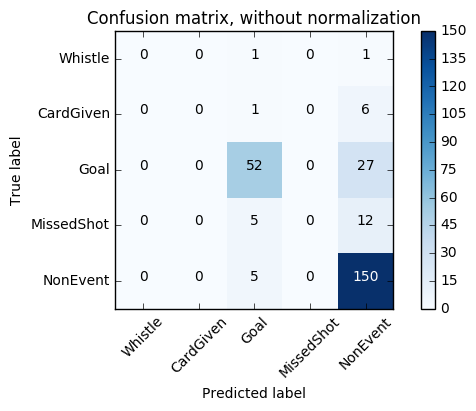

In [72]:
cnf_matrix = confusion_matrix(labels_test, test_predicted_labels_lm4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Whistle","CardGiven","Goal","MissedShot","NonEvent"],
                      title='Confusion matrix, without normalization')

In [40]:
test_predicted_labels_lm7 = lm7.predict(data_test)

wrong_prediction_lm7 = (test_predicted_labels_lm7 != labels_test)

print('number of incorrect predictions:', np.sum(wrong_prediction_lm7))

number of incorrect predictions: 61


In [41]:
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels_lm7 == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels_lm7, average="macro")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels_lm7, average="macro")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels_lm7, average="macro")))   

accuracy: 76.5%
F1 score: 31.3%
Precision: 30.7%
Recall: : 32.3%


Confusion matrix, without normalization
[[  0   0   1   0   1]
 [  0   0   1   0   6]
 [  0   0  53   1  25]
 [  0   0   5   0  12]
 [  0   0   9   0 146]]


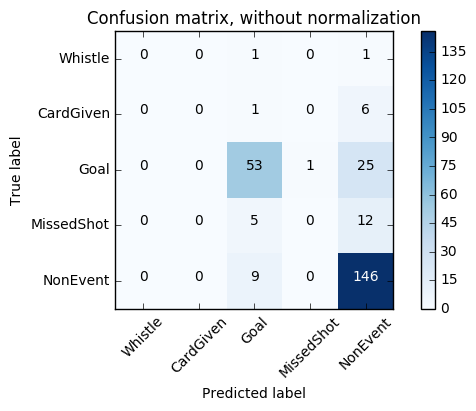

In [42]:
cnf_matrix = confusion_matrix(labels_test, test_predicted_labels_lm7)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Whistle","CardGiven","Goal","MissedShot","NonEvent"],
                      title='Confusion matrix, without normalization')

## Decision Trees & Random Forest

In [43]:
#data_train, data_test, labels_train, labels_test, index_train, index_test = train_test_split(data, labels, index, test_size=0.20, random_state=42)

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

from sklearn.datasets import make_gaussian_quantiles

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(data_train, labels_train)

print('Accuracy (a decision tree):', dt.score(data_test, labels_test))

dt1 = DecisionTreeClassifier(max_depth=4, criterion="entropy", splitter="best", random_state=0)
dt1.fit(data_train, labels_train)

print('Accuracy (a decision tree w/ max depth 4):', dt1.score(data_test, labels_test))


rfc = RandomForestClassifier(n_estimators=200, max_features=100, bootstrap=True, oob_score=True, min_samples_leaf=2)
rfc.fit(data_train, labels_train)

print('Accuracy (a random forest):', rfc.score(data_test, labels_test))

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=500, learning_rate=0.001)

abc.fit(data_train, labels_train)
print('Accuracy (adaboost with decision trees):', abc.score(data_test, labels_test))

Accuracy (a decision tree): 0.642307692308
Accuracy (a decision tree w/ max depth 4): 0.738461538462
Accuracy (a random forest): 0.796153846154
Accuracy (adaboost with decision trees): 0.742307692308


In [44]:
test_predicted_labels_rfc = rfc.predict(data_test)

wrong_prediction_rfc = (test_predicted_labels_rfc != labels_test)

print('number of incorrect predictions:', np.sum(wrong_prediction_rfc))

number of incorrect predictions: 53


In [45]:
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels_rfc == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels_rfc, average="macro")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels_rfc, average="macro")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels_rfc, average="macro")))   

accuracy: 79.6%
F1 score: 32.7%
Precision: 32%
Recall: : 33.9%


Confusion matrix, without normalization
[[  0   0   1   0   1]
 [  0   0   2   0   5]
 [  0   0  58   0  21]
 [  0   0   5   0  12]
 [  0   0   6   0 149]]


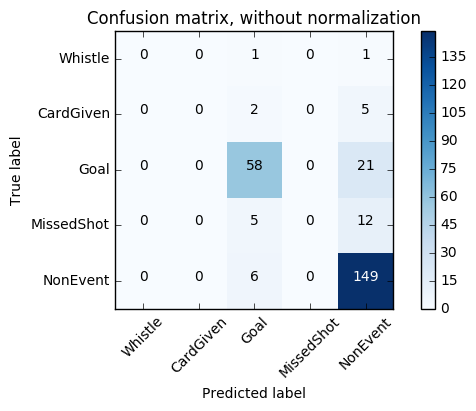

In [46]:
cnf_matrix = confusion_matrix(labels_test, test_predicted_labels_rfc)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Whistle","CardGiven","Goal","MissedShot","NonEvent"],
                      title='Confusion matrix, without normalization')

In [47]:
# from sklearn.metrics import roc_auc_score
# #Decison Tree Classifier
# dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0, class_weight = 'balanced')
# dt.fit(data_train, labels_train)

# print ('Accuracy (a decision tree):', roc_auc_score(labels_test, dt.predict(data_test)))

# rfc = RandomForestClassifier(n_estimators=200, class_weight = 'balanced')
# rfc.fit(data_train, labels_train)

# print ('Accuracy (a random forest):', roc_auc_score(labels_test, rfc.predict(data_test)))

# abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), n_estimators=200, learning_rate=0.1)

# abc.fit(data_train, labels_train)
# print ('Accuracy (a adaboost):', roc_auc_score(labels_test, abc.predict(data_test)))

In [48]:
from sklearn.ensemble import ExtraTreesClassifier

In [49]:
etc = ExtraTreesClassifier(max_depth=5000, min_samples_leaf=2, bootstrap=True, oob_score=True, max_features=100)
etc.fit(data_train, labels_train)

print('Accuracy (ExtraTreesClassifier):', etc.score(data_test, labels_test))

Accuracy (ExtraTreesClassifier): 0.761538461538


In [50]:
# Bagged Decision Tree
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cart = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, data_train, labels_train, cv=kfold)
print(results.mean())

0.766346153846


## Naive Bayes

In [51]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

In [52]:
ber = BernoulliNB()
ber.fit(data_train, labels_train)

print('Accuracy (Bernoulli):', ber.score(data_test, labels_test))

gau = GaussianNB()
gau.fit(data_train, labels_train)

print('Accuracy (Gaussian):', gau.score(data_test, labels_test))

Accuracy (Bernoulli): 0.688461538462
Accuracy (Gaussian): 0.392307692308


## Gradient Boosting Classifier

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

In [54]:
gra = GradientBoostingClassifier()
gra.fit(data_train, labels_train)

print('Accuracy (GBC):', gra.score(data_test, labels_test))

Accuracy (GBC): 0.792307692308


In [55]:
test_predicted_labels_gra = gra.predict(data_test)

wrong_prediction_gra = (test_predicted_labels_gra != labels_test)

print('number of incorrect predictions:', np.sum(wrong_prediction_gra))

number of incorrect predictions: 54


In [56]:
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels_gra == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels_gra, average="macro")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels_gra, average="macro")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels_gra, average="macro")))   

accuracy: 79.2%
F1 score: 36.4%
Precision: 45.5%
Recall: : 35.6%


Confusion matrix, without normalization
[[  0   0   1   0   1]
 [  0   0   1   0   6]
 [  0   0  56   0  23]
 [  0   0   4   2  11]
 [  0   0   6   1 148]]


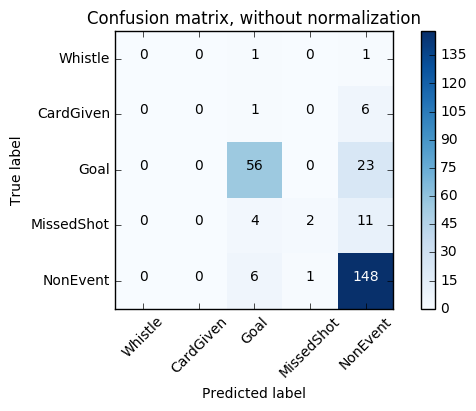

In [57]:
cnf_matrix = confusion_matrix(labels_test, test_predicted_labels_gra)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Whistle","CardGiven","Goal","MissedShot","NonEvent"],
                      title='Confusion matrix, without normalization')

## SVM

In [58]:
from sklearn.svm import LinearSVC

In [59]:
svc = LinearSVC(C=0.001)
svc.fit(data_train, labels_train)

print('Accuracy (svc):', svc.score(data_test, labels_test))

Accuracy (svc): 0.7


## Neural Network/Perceptron

In [60]:
from sklearn.linear_model import Perceptron

In [61]:
per = Perceptron()
per.fit(data_train, labels_train)

print('Accuracy (Perceptron):', per.score(data_test, labels_test))

Accuracy (Perceptron): 0.446153846154


In [62]:
from sklearn.neural_network import MLPClassifier

In [63]:
mlp = MLPClassifier(activation='logistic', solver='sgd', batch_size=10, momentum=0.95)
mlp.fit(data_train, labels_train)

print('Accuracy (mlp):', mlp.score(data_test, labels_test))

Accuracy (mlp): 0.784615384615


In [64]:
test_predicted_labels_mlp = mlp.predict(data_test)

wrong_prediction_mlp = (test_predicted_labels_mlp != labels_test)

print('number of incorrect predictions:', np.sum(wrong_prediction_mlp))

number of incorrect predictions: 56


In [65]:
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels_mlp == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels_mlp, average="macro")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels_mlp, average="macro")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels_mlp, average="macro")))   

accuracy: 78.5%
F1 score: 42%
Precision: 62.1%
Recall: : 38.6%


Confusion matrix, without normalization
[[  0   0   2   0   0]
 [  0   1   0   0   6]
 [  0   0  52   2  25]
 [  0   0   3   3  11]
 [  0   0   6   1 148]]


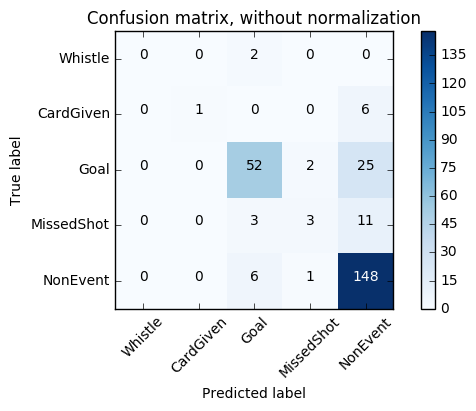

In [66]:
cnf_matrix = confusion_matrix(labels_test, test_predicted_labels_mlp)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Whistle","CardGiven","Goal","MissedShot","NonEvent"],
                      title='Confusion matrix, without normalization')

## Voting Classifier (Ensemble)
http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/

In [67]:
from sklearn import model_selection

clf1 = KNeighborsClassifier(n_neighbors=6)
clf2 = RandomForestClassifier(n_estimators=200, max_features=100, bootstrap=True, oob_score=True, min_samples_leaf=2)
clf3 = MLPClassifier(activation='logistic', solver='sgd', batch_size=10, momentum=0.95)
clf4 = GradientBoostingClassifier()
clf5 = LogisticRegression(multi_class='multinomial', solver='newton-cg', C=0.000002)

print('5-fold cross validation:\n')

labels = ['KNN6', 'Random Forest', 'MLPClassifier', 'GBC', 'LogisticRegression']

for clf, label in zip([clf1, clf2, clf3, clf4, clf5], labels):

    scores = model_selection.cross_val_score(clf, data_train, labels_train, 
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.77 (+/- 0.01) [KNN6]
Accuracy: 0.76 (+/- 0.02) [Random Forest]
Accuracy: 0.75 (+/- 0.03) [MLPClassifier]
Accuracy: 0.78 (+/- 0.02) [GBC]
Accuracy: 0.76 (+/- 0.03) [LogisticRegression]


In [69]:
from mlxtend.classifier import EnsembleVoteClassifier

eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3, clf4, clf5], weights=[3,1,1,2,1])

labels = ['KNN6', 'Random Forest', 'MLPClassifier', 'GBC', 'LogisticRegression', 'Ensemble']
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], labels):

    scores = model_selection.cross_val_score(clf, data_train, labels_train, 
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

Accuracy: 0.77 (+/- 0.01) [KNN6]
Accuracy: 0.76 (+/- 0.02) [Random Forest]
Accuracy: 0.78 (+/- 0.02) [MLPClassifier]
Accuracy: 0.78 (+/- 0.02) [GBC]
Accuracy: 0.76 (+/- 0.03) [LogisticRegression]
Accuracy: 0.79 (+/- 0.02) [Ensemble]


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB 
# from sklearn.ensemble import RandomForestClassifier
# from mlxtend.classifier import EnsembleVoteClassifier

# clf1 = LogisticRegression(random_state=1)
# clf2 = RandomForestClassifier(random_state=1)
# clf3 = GaussianNB()
# eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], voting='soft')

# params = {'logisticregression__C': [1.0, 100.0],
#           'randomforestclassifier__n_estimators': [20, 200],}

# grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
# grid.fit(data_train, labels_train)

# cv_keys = ('mean_test_score', 'std_test_score', 'params')

# for r, _ in enumerate(grid.cv_results_['mean_test_score']):
#     print("%0.3f +/- %0.2f %r"
#           % (grid.cv_results_[cv_keys[0]][r],
#              grid.cv_results_[cv_keys[1]][r] / 2.0,
#              grid.cv_results_[cv_keys[2]][r]))